In [1]:
#####1.数据信息查看和数据清洗
####导入和查看数据
import pandas as pd
data = pd.read_csv('hotel_bookings.csv')
data.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

In [2]:
data.info()
#######初步分析有32列数据，其中存在有缺失值，有contry、agent等

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [3]:
######接下来对缺失数据进行查看

data.isnull().sum()[data.isnull().sum()!=0]

#####其中有四项信息存在缺失值，company缺失较多，可以考虑删除，
#####children和country、agent较少，可以考虑填充

children         4
country        488
agent        16340
company     112593
dtype: int64

In [4]:
#####处理方法：
    ###假设agent中缺失值代表未指定任何机构，即nan=0
    ###country则直接使用其字段内众数填充
    ###childred使用其字段内众数填充
    ###company因缺失数值过大，且其信息较杂（单个值分布太多），所以直接删除

#####首先删除company列：
data_new = data.copy(deep = True)
data_new.drop("company", axis=1, inplace=True)

In [5]:
#####然后对children和country、agent进行填充。
#####查看children和country、agent的信息
data[['children','agent','country']]

children  agent country
0            0.0    NaN     PRT
1            0.0    NaN     PRT
2            0.0    NaN     GBR
3            0.0  304.0     GBR
4            0.0  240.0     GBR
...          ...    ...     ...
119385       0.0  394.0     BEL
119386       0.0    9.0     FRA
119387       0.0    9.0     DEU
119388       0.0   89.0     GBR
119389       0.0    9.0     DEU

[119390 rows x 3 columns]

In [6]:
######对children和country、agent进行填充
data_new["agent"].fillna(0, inplace=True)
data_new["children"].fillna(data_new["children"].mode()[0], inplace=True)
data_new["country"].fillna(data_new["country"].mode()[0], inplace=True)

data_new.info()#####再次查看信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [7]:
######在后面计算人均价格的时候，如果总人数和为0的情况，则会有异常，所以需要处理异常值
#####需要对此数据集中异常值为那些总人数（adults+children+babies)为0的记录，
#####同时，因为先前已指名“meal”中“SC”和“Undefined”为同一类别，因此也需要处理一下

data_new["children"] = data_new["children"].astype(int)
data_new["agent"] = data_new["agent"].astype(int)

data_new["meal"].replace("Undefined", "SC", inplace=True)
# 处理异常值
# 将 变量 adults + children + babies == 0 的数据删除
zero_guests = list(data_new["adults"] +
                  data_new["children"] +
                  data_new["babies"] == 0)
# hb_new.info()
data_new.drop(data_new.index[zero_guests], inplace=True)
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119210 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119210 non-null  object 
 1   is_canceled                     119210 non-null  int64  
 2   lead_time                       119210 non-null  int64  
 3   arrival_date_year               119210 non-null  int64  
 4   arrival_date_month              119210 non-null  object 
 5   arrival_date_week_number        119210 non-null  int64  
 6   arrival_date_day_of_month       119210 non-null  int64  
 7   stays_in_weekend_nights         119210 non-null  int64  
 8   stays_in_week_nights            119210 non-null  int64  
 9   adults                          119210 non-null  int64  
 10  children                        119210 non-null  int32  
 11  babies                          119210 non-null  int64  
 12  meal            

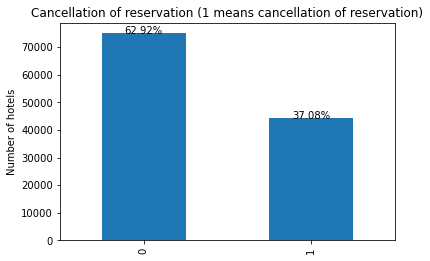

<Figure size 432x288 with 0 Axes>

In [8]:
######### 2.数据分析(数据可视化)
####2.1入住率和取消数
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数
data_new.is_canceled.value_counts().plot(kind='bar')# 柱状图 
plt.title(u"Cancellation of reservation (1 means cancellation of reservation)") # 标题
plt.ylabel(u"Number of hotels")  
cancel = data_new.is_canceled.value_counts()
Sum=cancel.sum()
count=0
for i in cancel:   # 显示百分比
    plt.text(count,i+0.5, str('{:.2f}'.format(cancel[count]/Sum *100)) +'%', \
    ha='center') #位置，高度，内容，居中
    count= count + 1
plt.show()
plt.savefig("E:/jupyter图像文件/入住率和取消数")

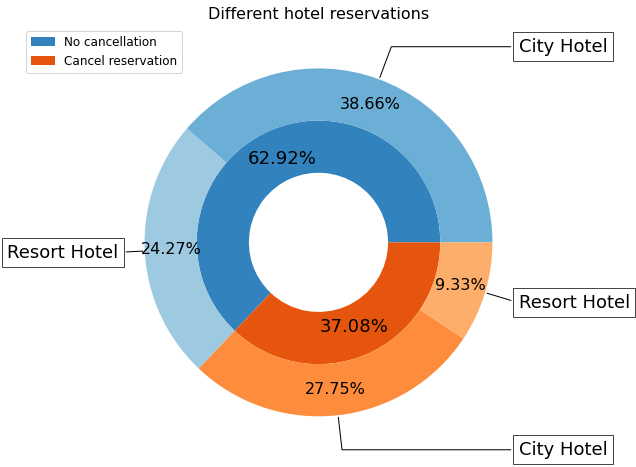

In [9]:
####查看不同酒店的入住率与取消率

import numpy as np

rh_iscancel_count = data_new[data_new["hotel"]=="Resort Hotel"].groupby(["is_canceled"])["is_canceled"].count()
ch_iscancel_count = data_new[data_new["hotel"]=="City Hotel"].groupby(["is_canceled"])["is_canceled"].count()

rh_cancel_data = pd.DataFrame({"hotel": "Resort Hotel",
                              "is_canceled": rh_iscancel_count.index,
                              "count": rh_iscancel_count.values})

ch_cancel_data = pd.DataFrame({"hotel": "City Hotel",
                              "is_canceled": ch_iscancel_count.index,
                              "count": ch_iscancel_count.values})
iscancel_data = pd.concat([rh_cancel_data, ch_cancel_data], ignore_index=True)
plt.figure(figsize=(12, 8))

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap(np.array([1, 2, 5, 6]))

w , t, at = plt.pie(data_new["is_canceled"].value_counts(), autopct="%.2f%%",textprops={"fontsize":18},
                   radius=0.7, wedgeprops=dict(width=0.3), pctdistance=0.75, colors=outer_colors)
plt.legend(w, ["No cancellation", "Cancel reservation"], loc="upper right", bbox_to_anchor=(0, 0, 0.2, 1), fontsize=12)


val_array = np.array((iscancel_data.loc[(iscancel_data.hotel=="City Hotel")&(iscancel_data.is_canceled==0), "count"].values,
       iscancel_data.loc[(iscancel_data.hotel=="Resort Hotel")&(iscancel_data.is_canceled==0), "count"].values,
       iscancel_data.loc[(iscancel_data.hotel=="City Hotel")&(iscancel_data.is_canceled==1), "count"].values,
       iscancel_data.loc[(iscancel_data.hotel=="Resort Hotel")&(iscancel_data.is_canceled==1), "count"].values))

val_array = np.squeeze(val_array)
w2, t2, at2 = plt.pie(val_array, autopct="%.2f%%",textprops={"fontsize":16}, radius=1,
       wedgeprops=dict(width=0.3), pctdistance=0.85, colors=inner_colors)
plt.title("Different hotel reservations", fontsize=16)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color="k"), bbox=bbox_props, zorder=3, va="center")
for i, p in enumerate(w2):
#     print(i, p, sep="---")
    text = ["City Hotel", "Resort Hotel", "City Hotel", "Resort Hotel"]
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle, angleA=0, angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate(text[i], xy=(x, y), xytext=(1.15*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, **kw, fontsize=18)
    


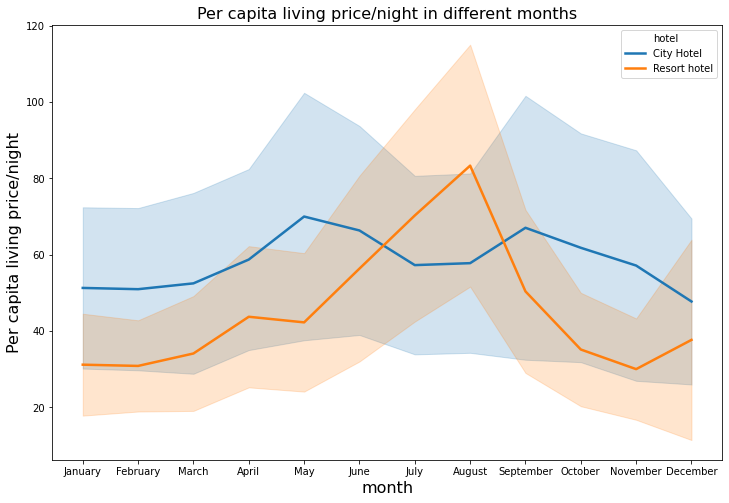

In [10]:
#### 2.2酒店人均价格
####因为babies年龄过小，所以人均价格中未将babies带入计算。
####此时来查看不同月份下的平均酒店价格

import seaborn as sns

data_new["adr_pp"] = data_new["adr"] / (data_new["adults"] + data_new["children"])
full_data_guests = data_new.loc[data_new["is_canceled"] == 0] # only actual gusts
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")
room_price_monthly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August",
                 "September", "October", "November", "December"]
month_che = ['January','February','March','April','May','June','July','August','September','October','November','December', ]

for en, che in zip(ordered_months, month_che):
    room_price_monthly["arrival_date_month"].replace(en, che, inplace=True)
room_price_monthly["arrival_date_month"] = pd.Categorical(room_price_monthly["arrival_date_month"],
                                                         categories=month_che, ordered=True)
room_price_monthly["hotel"].replace("City Hotel", "City Hotel", inplace=True)
room_price_monthly["hotel"].replace("Resort Hotel", "Resort hotel", inplace=True)
room_price_monthly.head(15)

plt.figure(figsize=(12, 8))
sns.lineplot(x="arrival_date_month", y="adr_pp", hue="hotel", data=room_price_monthly,
            hue_order=["City Hotel", "Resort hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Per capita living price/night in different months", fontsize=16)
plt.xlabel("month", fontsize=16)
plt.ylabel("Per capita living price/night", fontsize=16)
plt.savefig("E:/jupyter图像文件/不同月份人均居住价格每晚")

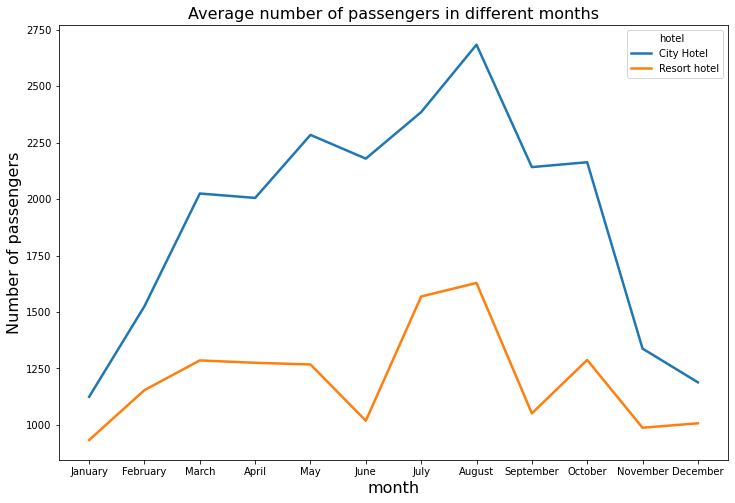

In [11]:
####2.3查看月度人流量
rh_bookings_monthly = full_data_guests[full_data_guests.hotel=="Resort Hotel"].groupby("arrival_date_month")["hotel"].count()
ch_bookings_monthly = full_data_guests[full_data_guests.hotel=="City Hotel"].groupby("arrival_date_month")["hotel"].count()

rh_bookings_data = pd.DataFrame({"arrival_date_month": list(rh_bookings_monthly.index),
                                "hotel": "Resort hotel",
                                "guests": list(rh_bookings_monthly.values)})
ch_bookings_data = pd.DataFrame({"arrival_date_month": list(ch_bookings_monthly.index),
                                "hotel": "City Hotel",
                                "guests": list(ch_bookings_monthly.values)})
full_booking_monthly_data = pd.concat([rh_bookings_data, ch_bookings_data], ignore_index=True)

ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August",
                 "September", "October", "November", "December"]
month_che = ['January','February','March','April','May','June','July','August','September','October','November','December', ]

for en, che in zip(ordered_months, month_che):
    full_booking_monthly_data["arrival_date_month"].replace(en, che, inplace=True)

full_booking_monthly_data["arrival_date_month"] = pd.Categorical(full_booking_monthly_data["arrival_date_month"],
                                                      categories=month_che, ordered=True)

full_booking_monthly_data.loc[(full_booking_monthly_data["arrival_date_month"]=="七月")|\
                             (full_booking_monthly_data["arrival_date_month"]=="八月"), "guests"] /= 3
full_booking_monthly_data.loc[~((full_booking_monthly_data["arrival_date_month"]=="七月")|\
                             (full_booking_monthly_data["arrival_date_month"]=="八月")), "guests"] /= 2
plt.figure(figsize=(12, 8))
sns.lineplot(x="arrival_date_month",
            y="guests",
            hue="hotel", hue_order=["City Hotel", "Resort hotel"],
            data=full_booking_monthly_data, size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of passengers in different months", fontsize=16)
plt.xlabel("month", fontsize=16)
plt.ylabel("Number of passengers", fontsize=16)
plt.savefig("E:/jupyter图像文件/不同月份平均旅客数")

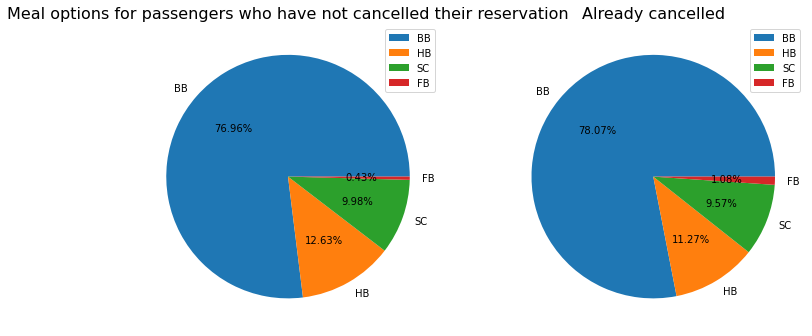

In [12]:
####2.4餐食选择

meal_data = data_new[["hotel", "is_canceled", "meal"]]
# meal_data

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.pie(meal_data.loc[meal_data["is_canceled"]==0, "meal"].value_counts(), 
        labels=meal_data.loc[meal_data["is_canceled"]==0, "meal"].value_counts().index, 
       autopct="%.2f%%")
plt.title("Meal options for passengers who have not cancelled their reservation", fontsize=16)
plt.legend(loc="upper right")

plt.subplot(122)
plt.pie(meal_data.loc[meal_data["is_canceled"]==1, "meal"].value_counts(), 
        labels=meal_data.loc[meal_data["is_canceled"]==1, "meal"].value_counts().index, 
       autopct="%.2f%%")
plt.title("Already cancelled", fontsize=16)
plt.legend(loc="upper right")
plt.savefig("E:/jupyter图像文件/餐食选择")

D:\small soft\Anacond\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\small soft\Anacond\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\small soft\Anacond\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

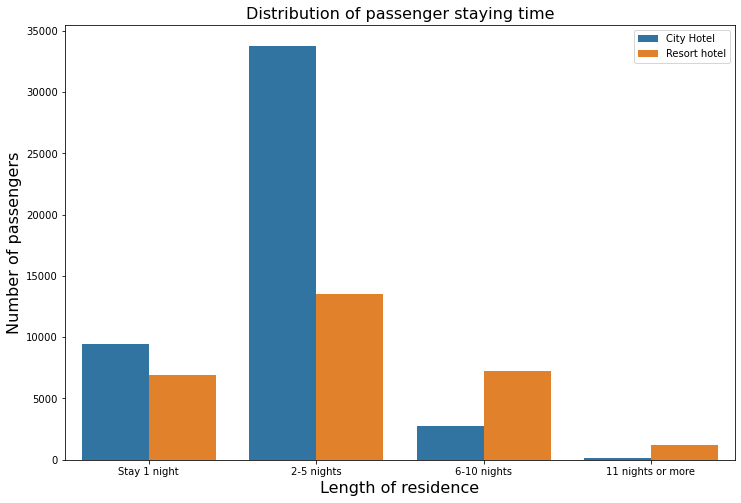

In [13]:
#####2.5居住时长
###在不同酒店居住的旅客通常会选择住几天呢？我们可以使用柱形图来看一下其时长的不同分布；
###首先计算出总时长：总时长=周末停留夜晚数+工作日停留夜晚数

full_data_guests["total_nights"] = full_data_guests["stays_in_weekend_nights"] + full_data_guests["stays_in_week_nights"]

# 新建字段：total_nights_bin——居住时长区间
full_data_guests["total_nights_bin"] = "Stay 1 night"
full_data_guests.loc[(full_data_guests["total_nights"]>1)&(full_data_guests["total_nights"]<=5), "total_nights_bin"] = "2-5 nights"
full_data_guests.loc[(full_data_guests["total_nights"]>5)&(full_data_guests["total_nights"]<=10), "total_nights_bin"] = "6-10 nights"
full_data_guests.loc[(full_data_guests["total_nights"]>10), "total_nights_bin"] = "11 nights or more"

ch_nights_count = full_data_guests["total_nights_bin"][full_data_guests.hotel=="City Hotel"].value_counts()
rh_nights_count = full_data_guests["total_nights_bin"][full_data_guests.hotel=="Resort Hotel"].value_counts()

ch_nights_index = full_data_guests["total_nights_bin"][full_data_guests.hotel=="City Hotel"].value_counts().index
rh_nights_index = full_data_guests["total_nights_bin"][full_data_guests.hotel=="Resort Hotel"].value_counts().index

ch_nights_data = pd.DataFrame({"hotel": "City Hotel",
                               "nights": ch_nights_index,
                              "guests": ch_nights_count})
rh_nights_data = pd.DataFrame({"hotel": "Resort hotel",
                               "nights": rh_nights_index,
                              "guests": rh_nights_count})
# 绘图数据
nights_data = pd.concat([ch_nights_data, rh_nights_data], ignore_index=True)
order = ["Stay 1 night", "2-5 nights", "6-10 nights", "11 nights or more"]
nights_data["nights"] = pd.Categorical(nights_data["nights"], categories=order, ordered=True)

plt.figure(figsize=(12, 8))
sns.barplot(x="nights", y="guests", hue="hotel", data=nights_data)
plt.title("Distribution of passenger staying time", fontsize=16)
plt.xlabel("Length of residence", fontsize=16)
plt.ylabel("Number of passengers", fontsize=16)

plt.legend()
plt.savefig("E:/jupyter图像文件/居住时长")

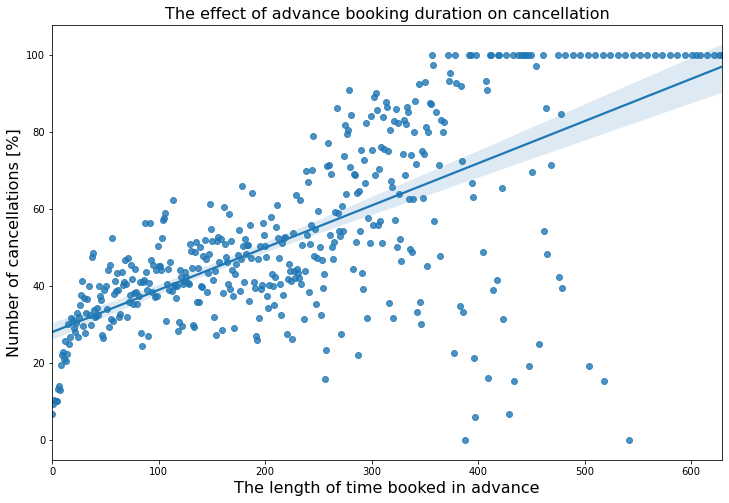

In [14]:
#####2.6提前预定时长

lead_cancel_data = pd.DataFrame(data_new.groupby("lead_time")["is_canceled"].describe())
# lead_cancel_data
# 因为lead_time中值范围大且数量分布不匀，所以选取lead_time>10次的数据（<10的数据不具代表性）
lead_cancel_data_10 = lead_cancel_data[lead_cancel_data["count"]>10]

y = list(round(lead_cancel_data_10["mean"], 4) * 100)

plt.figure(figsize=(12, 8))
sns.regplot(x=list(lead_cancel_data_10.index),
           y=y)
plt.title("The effect of advance booking duration on cancellation", fontsize=16)
plt.xlabel("The length of time booked in advance", fontsize=16)
plt.ylabel("Number of cancellations [%]", fontsize=16)

plt.savefig("E:/jupyter图像文件/提前预定时长对取消的影响")

In [15]:
####3.进行各属性的分辨，哪个更重要
####利用data.corr()进行相关性的判断 #相关系数矩阵

cancel_corr = data_new.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
agent                             0.046770
adr                               0.046492
babies                            0.032569
stays_in_week_nights              0.025542
adr_pp                            0.017808
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_day_of_month         0.005948
children                          0.004851
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

In [16]:
data_new.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75011
1            Canceled              42993
             No-Show                1206
Name: reservation_status, dtype: int64

In [17]:
#####4.特征模型训练

#####导入模块
# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  # 随机森林
from xgboost import XGBClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # Feature importance evaluation

D:\small soft\Anacond\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\small soft\Anacond\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
D:\small soft\Anacond\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synony

In [18]:
#手动选择要包括的列
#为了使模型更通用并防止泄漏，排除了一些列
#（到达日期、年份、指定房间类型、预订更改、预订状态、国家/地区，
#等待日列表）
#包括国家将提高准确性，但它也可能使模型不那么通用
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]
#分离特征和预测值
features = num_features + cat_features
X = data_new.drop(["is_canceled"], axis=1)[features]
y = data_new["is_canceled"]

In [19]:
#预处理数值特征：
#对于大多数num cols，除了日期，0是最符合逻辑的填充值
#这里没有日期遗漏。
num_transformer = SimpleImputer(strategy="constant")

# 分类特征的预处理：
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# 数值和分类特征的束预处理：
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

# 定义要测试的模型：
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

#将数据分成“kfold”部分进行交叉验证，
#使用shuffle确保数据的随机分布：
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

#对每个模型进行预处理、拟合、预测和评分：
for name, model in base_models:
    #将数据和模型的预处理打包到管道中：
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    #获取每个模型的交叉验证分数：
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    ###可以看到采用随机森林RF_model的效果最好。可以继续对其进行一些超参数的优化。   


DT_model cross validation accuarcy score: 0.8255 +/- 0.0012 (std) min: 0.8241, max: 0.827
RF_model cross validation accuarcy score: 0.8663 +/- 0.0005 (std) min: 0.8653, max: 0.8667
LR_model cross validation accuarcy score: 0.7958 +/- 0.0015 (std) min: 0.7942, max: 0.7981
XGB_model cross validation accuarcy score: 0.8465 +/- 0.0008 (std) min: 0.8452, max: 0.8474


In [20]:
###随机森林RF_model的参数优化
# Enhanced RF model with the best parameters I found:
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")


Enhanced RF model cross validation accuarcy score: 0.8677 +/- 0.002 (std) min: 0.8644, max: 0.8694


In [21]:
####5.评价特征的重要性

#拟合模型，以便可以访问值：
model_pipe.fit(X,y)

#需要所有（编码）功能的名称。
#从一个热编码中获取列的名称：
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#为完整列表添加num_功能。
#顺序必须与X的定义相同，其中num_特征是第一个：
feat_imp_list = num_features + onehot_columns

#显示10个最重要的功能，提供功能名称：
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
feat_imp_df.head(10)

feature    weight       std
0                  lead_time  0.147600  0.016220
1    deposit_type_Non Refund  0.125262  0.105452
2                        adr  0.095783  0.003034
3    deposit_type_No Deposit  0.082456  0.104191
4  arrival_date_day_of_month  0.069756  0.002014
5   arrival_date_week_number  0.054233  0.002209
6  total_of_special_requests  0.052263  0.013690
7                      agent  0.044549  0.008302
8     previous_cancellations  0.042619  0.015747
9       stays_in_week_nights  0.041544  0.002334

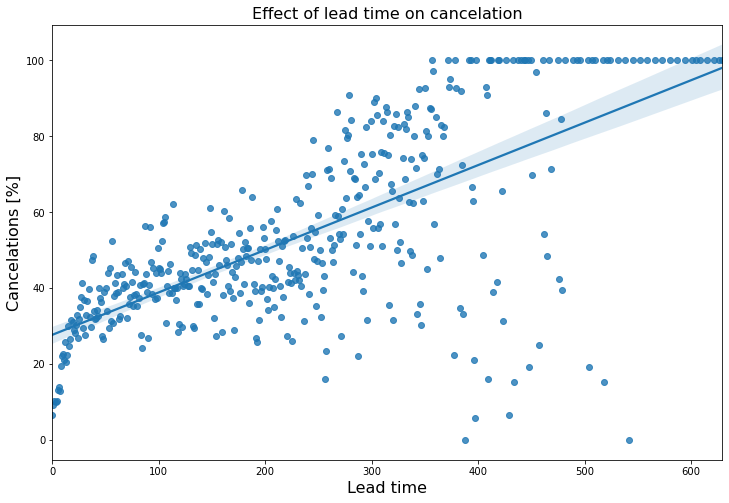

<Figure size 432x288 with 0 Axes>

In [22]:
####查看三个最重要的功能：
### lead_time，deposit_type，adr

####1.lead_time的功能

# group data for lead_time:
lead_cancel_data = data_new.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()
plt.savefig("E:/jupyter图像文件/lead_time")

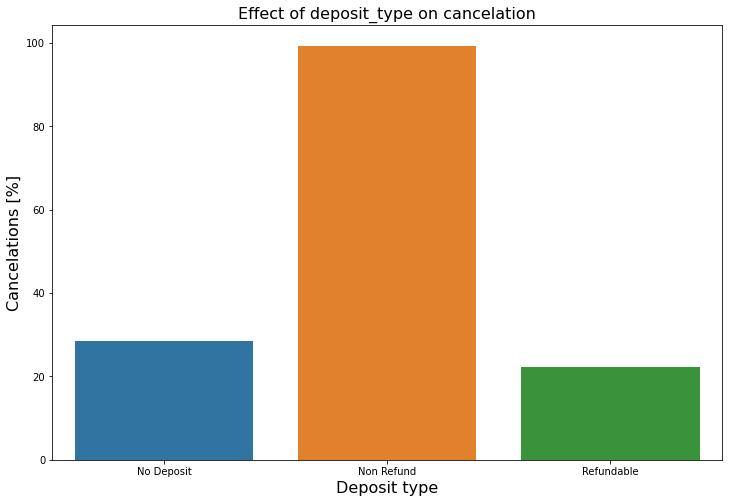

<Figure size 432x288 with 0 Axes>

In [23]:
#####2.deposit_type的功能

# group data for deposit_type:
deposit_cancel_data = data_new.groupby("deposit_type")["is_canceled"].describe()

#show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x=deposit_cancel_data.index, y=deposit_cancel_data["mean"] * 100)
plt.title("Effect of deposit_type on cancelation", fontsize=16)
plt.xlabel("Deposit type", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

plt.savefig("E:/jupyter图像文件/deposit")

In [24]:
######以下是按存款类型分组的所有数据平均值表：
deposit_mean_data = data_new.groupby("deposit_type").mean()
deposit_mean_data

##将不退款和不存款的平均值进行比较，结果如下：

##不退还押金的特点是提前期延长2倍以上
###重复的客人是~1/10
##以前的取消次数是以前的10倍
##以前的预订没有取消是1/15
##所需的停车位几乎为零
##特殊要求非常罕见

is_canceled   lead_time  arrival_date_year  \
deposit_type                                               
No Deposit       0.284020   88.841951        2016.173950   
Non Refund       0.993624  212.908891        2016.031466   
Refundable       0.222222  152.098765        2016.141975   

              arrival_date_week_number  arrival_date_day_of_month  \
deposit_type                                                        
No Deposit                   27.133208                  15.815223   
Non Refund                   27.448619                  15.595462   
Refundable                   20.932099                  23.456790   

              stays_in_weekend_nights  stays_in_week_nights    adults  \
deposit_type                                                            
No Deposit                   0.969615              2.555633  1.865806   
Non Refund                   0.621718              2.091109  1.811407   
Refundable                   0.975309              2.851852  1.907407   

              children    babies  is_repeated_guest  previous_cancellations  \
deposit_type                                                                  
No Deposit    0.118599  0.009085           0.035295                0.042044   
Non Refund    0.000617  0.000000           0.004387                0.411462   
Refundable    0.030864  0.000000           0.024691                0.000000   

              previous_bookings_not_canceled  booking_changes      agent  \
deposit_type                                                               
No Deposit                          0.154938         0.247030  78.745503   
Non Refund                          0.010626         0.012477  47.480016   
Refundable                          0.018519         0.592593  56.185185   

              days_in_waiting_list         adr  required_car_parking_spaces  \
deposit_type                                                                  
No Deposit                1.518040  103.685436                     0.071184   
Non Refund                7.992253   89.964017                     0.000069   
Refundable                9.586420   76.209753                     0.123457   

              total_of_special_requests     adr_pp  
deposit_type                                        
No Deposit                     0.651726  55.231806  
Non Refund                     0.001782  54.520286  
Refundable                     0.141975  41.444239

In [25]:
cat_features_non_dep = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","customer_type"]

features_non_dep = num_features + cat_features_non_dep
X_non_dep = data_new.drop(["is_canceled"], axis=1)[features_non_dep]


# Bundle preprocessing for numerical and categorical features:
preprocessor_non_dep = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features_non_dep)])

# Define dataset:
X_non_dep = data_new.drop(["is_canceled"], axis=1)[features_non_dep]
# Define model
rf_model_non_dep = RandomForestClassifier(random_state=42) # basic model for this purpose

kfolds=4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor_non_dep),
                              ('model', rf_model_non_dep)])
cv_results = cross_val_score(model_pipe, 
                                 X_non_dep, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"RF model without deposit_type feature cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

RF model without deposit_type feature cross validation accuarcy score: 0.8657 +/- 0.0003 (std) min: 0.8653, max: 0.8662
